In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import numpy as np
from py4j.java_gateway import JavaGateway, GatewayParameters

In [2]:
# Retrieve OpenSHA objects from the JavaGateway

gateway = JavaGateway(gateway_parameters=GatewayParameters(auto_field=True, auto_convert=True))
app = gateway.entry_point
rup_set = app.loadRupSet("rupSetBruceRundir5883.zip")
sections = rup_set.getFaultSectionDataList()
coulomb = app.getCoulombTester(rup_set, "stiffnessCaches")
coulomb.setupStiffness()
filters = coulomb.getFilters()
jumps = coulomb.getJumps(rup_set)

agg_calc_1 = filters[1].getAggCalc()
threshold_1 = filters[1].getThreshold()



In [12]:
# area calculations are expensive, we isolate them in this cell to avoid repeats
sqk = 1.0/1000000  

def rupture_area(rupture):
    return sum([s.getArea(False) * sqk for s in rupture.buildOrderedSectionList()])

# total area of subduction component
sub_areas = np.array([rupture_area(j.fromRupture) for j in jumps])
# total area of crustal component
cru_areas = np.array([rupture_area(j.toRupture) for j in jumps])

In [34]:
# Collect rupture stats

# filter passes
filter_0_passes = np.array([filters.get(0).apply(j, False).isPass() for j in jumps])
filter_1_passes = np.array([filters.get(1).apply(j, False).isPass() for j in jumps])

def filter_stats(agg_calc, threshold, ruptureId):
    sectionIds = rup_set.getSectionsIndicesForRup(ruptureId)
    rupture = [sections.get(s) for s in sectionIds]
    subduction = [s for s in rupture if "row:" in s.getSectionName()]
    crustal = [s for s in rupture if "row:" not in s.getSectionName()]
    return [
        # area of passing target crustal sections
        sum([s.getArea(False) * sqk for s in crustal if agg_calc.calc(subduction, [s]) >= threshold]),
        # subduction->crustal stiffness, can be used to check if filter would pass
        agg_calc.calc(subduction, crustal),
        agg_calc.calc(crustal, subduction)
    ]

filter_1_stats = [filter_stats(agg_calc_1, threshold_1, r) for r in range(rup_set.getNumRuptures())]
filter_1_pass = np.array([ps for (ps, sc, cs) in filter_1_stats])

MultiRuptureFractCoulombPositiveFilter pass count 3
MultiRuptureNetCoulombPositiveFilter pass count 173


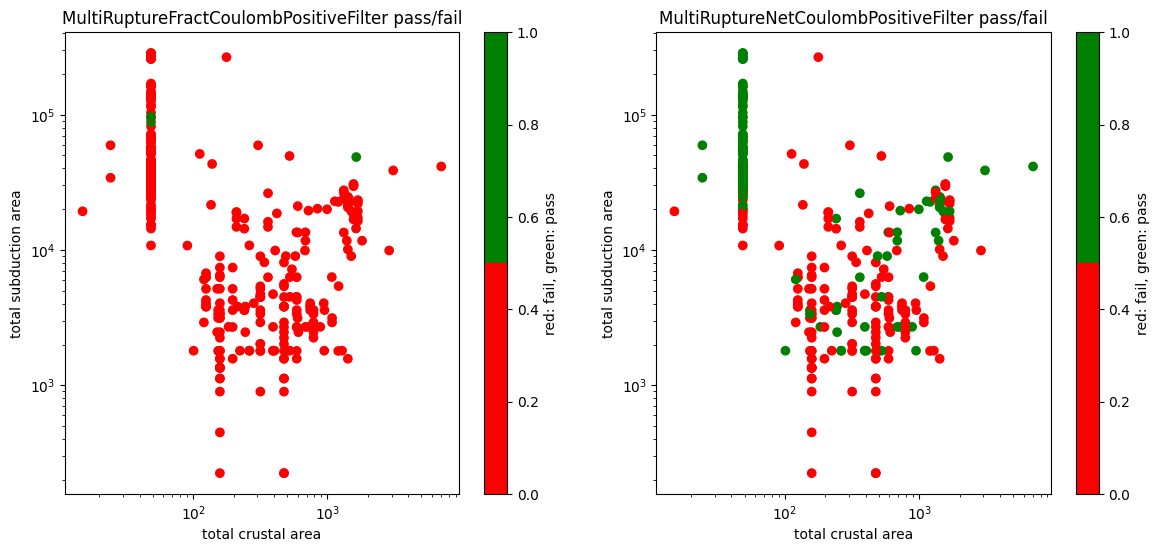

In [35]:
pass_count_0 = sum(p for p in filter_0_passes)
pass_count_1 = sum(p for p in filter_1_passes)

print("MultiRuptureFractCoulombPositiveFilter pass count", pass_count_0)
print("MultiRuptureNetCoulombPositiveFilter pass count", pass_count_1)

cmap = colors.ListedColormap(['red', 'green'])
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
scatter = axs[0].scatter(cru_areas, sub_areas, c=filter_0_passes, cmap=cmap)
axs[0].set_title("MultiRuptureFractCoulombPositiveFilter pass/fail")
axs[0].set_ylabel("total subduction area")
axs[0].set_yscale('log')
axs[0].set_xlabel('total crustal area')
axs[0].set_xscale('log')
fig.colorbar(scatter).set_label("red: fail, green: pass")

scatter = axs[1].scatter(cru_areas, sub_areas, c=filter_1_passes, cmap=cmap)
axs[1].set_title("MultiRuptureNetCoulombPositiveFilter pass/fail")
axs[1].set_ylabel("total subduction area")
axs[1].set_yscale('log')
axs[1].set_xlabel('total crustal area')
axs[1].set_xscale('log')
fig.colorbar(scatter).set_label("red: fail, green: pass")



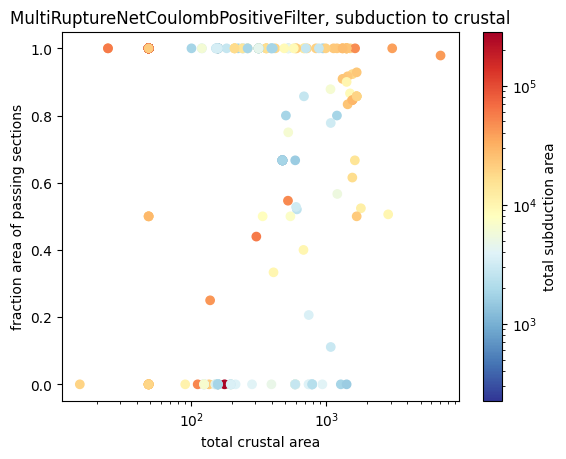

In [16]:
y = np.divide(filter_1_pass, cru_areas) # array( [ps/cs for (cs, ss, ps, ok) in stats])
plt.scatter(cru_areas, y, c=sub_areas, cmap='RdYlBu_r', norm=colors.LogNorm())
plt.title("MultiRuptureNetCoulombPositiveFilter, subduction to crustal")
plt.ylabel('fraction area of passing sections')
#plt.yscale('log')
plt.xlabel('total crustal area')
plt.xscale('log')

#plt.axhline(y=0.5, color='r', linestyle='-.')
color_bar = plt.colorbar()
color_bar.set_label("total subduction area")
plt.show()

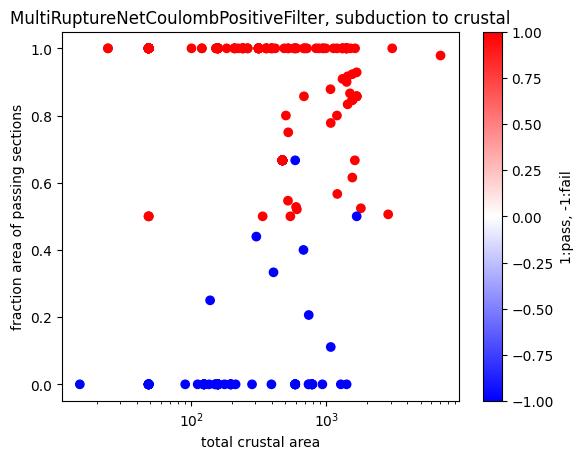

In [9]:
x = np.array([cs for (cs, ss, ps, ok) in stats])
y = np.array([ps/cs for (cs, ss, ps, ok) in stats])
cs = np.array([1 if ok>0 else -1 for (cs, ss, ps, ok) in stats])
plt.scatter(x, y, c=cs, cmap="bwr")
plt.title("MultiRuptureNetCoulombPositiveFilter, subduction to crustal")
plt.ylabel('fraction area of passing sections')
#plt.yscale('log')
plt.xlabel('total crustal area')
plt.xscale('log')
color_bar = plt.colorbar()
color_bar.set_label("1:pass, -1:fail")
plt.show()

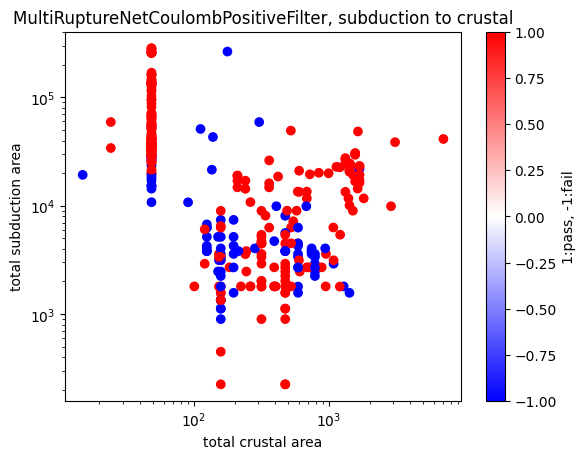

In [10]:
x = np.array([cs for (cs, ss, ps, ok) in stats])
y = np.array([ss for (cs, ss, ps, ok) in stats])
values = np.array([1 if ok>0 else -1 for (cs, ss, ps, ok) in stats])
plt.scatter(x, y, c=values, cmap="bwr")#, norm=colors.LogNorm())
plt.title("MultiRuptureNetCoulombPositiveFilter, subduction to crustal")
plt.ylabel("total subduction area")
plt.yscale('log')
plt.xlabel('total crustal area')
plt.xscale('log')
color_bar = plt.colorbar()
color_bar.set_label("1:pass, -1:fail")
plt.show()

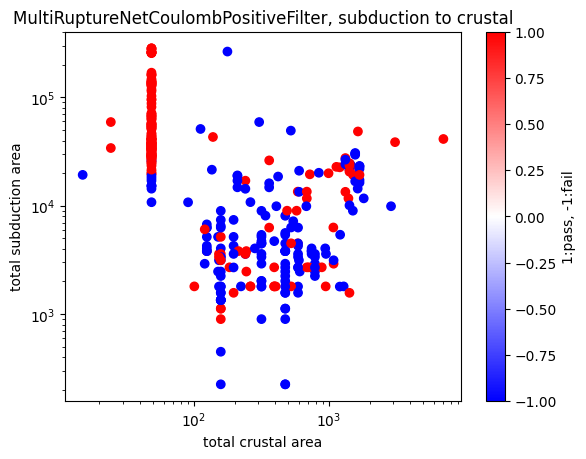

In [14]:
x = np.array([cs for (cs, ss, ps, ok, ok2) in stats])
y = np.array([ss for (cs, ss, ps, ok, ok2) in stats])
values = np.array([1 if ok2>0 else -1 for (cs, ss, ps, ok, ok2) in stats])
plt.scatter(x, y, c=values, cmap="bwr")#, norm=colors.LogNorm())
plt.title("MultiRuptureNetCoulombPositiveFilter, subduction to crustal")
plt.ylabel("total subduction area")
plt.yscale('log')
plt.xlabel('total crustal area')
plt.xscale('log')
color_bar = plt.colorbar()
color_bar.set_label("1:pass, -1:fail")
plt.show()

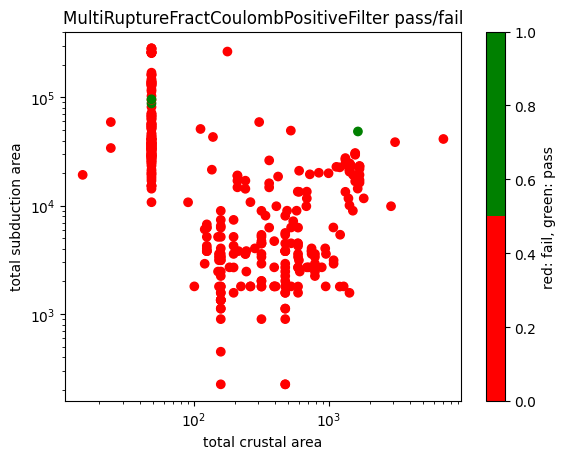

In [48]:
cmap = colors.ListedColormap(['red', 'green'])
x = np.array(to_areas)
y = np.array(from_areas)
values = np.array(filter_0_passes)
plt.scatter(x, y, c=values, cmap=cmap)#, norm=colors.LogNorm())
plt.title("MultiRuptureFractCoulombPositiveFilter pass/fail")
plt.ylabel("total subduction area")
plt.yscale('log')
plt.xlabel('total crustal area')
plt.xscale('log')
color_bar = plt.colorbar()
color_bar.set_label("red: fail, green: pass")
plt.show()

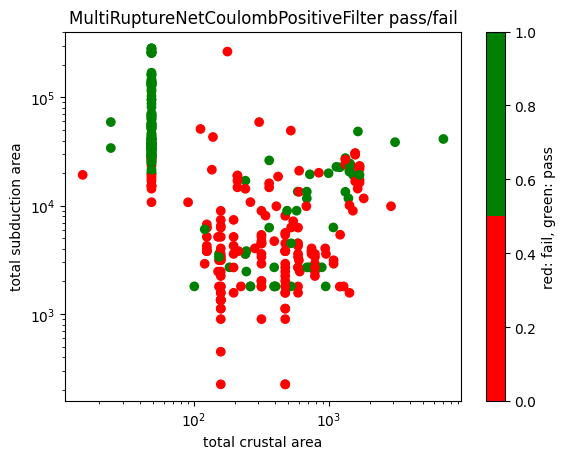

In [49]:
values = np.array(filter_1_passes)
plt.scatter(x, y, c=values, cmap=cmap)#, norm=colors.LogNorm())
plt.title("MultiRuptureNetCoulombPositiveFilter pass/fail")
plt.ylabel("total subduction area")
plt.yscale('log')
plt.xlabel('total crustal area')
plt.xscale('log')
color_bar = plt.colorbar()
color_bar.set_label("red: fail, green: pass")
plt.show()